In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [2]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [3]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [4]:
import os
from pathlib import Path

from scripts.get_data import save_data

# save_data()

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
train_dir = image_path / 'train'
test_dir = image_path / 'test'

# 2. Set up the image transforms
In order to use the model on our data, we need to put the data into the same shape as the data used to actually train the model. We can either do this automatically or manually. 
- The manual way is we define a transform Compose function that takes in an image and transforms it into the correct shape
- The automatic way accesses the transforms built into the model and we can just apply those to our data

In [5]:
from scripts import data_setup

# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

# Or you can use the auto generation of the transforms belonging to the dataset
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
auto_transforms = weights.transforms()
auto_transforms

# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x12f2840d0>,
 ['pizza', 'steak', 'sushi'])

# 3. Get the pre-trained model
The idea of transfer learning is to take an already well performing model on a similar problem space and customize it to our specific use case. 
\
\
Here we will be using TorchVision's EfficientNet model. And we're just going to change the model's output layer to compensate for our three different classification classes. 

In [6]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights)

#model # uncomment to output (it's very long)

We want to generate a summary of the model that we're going to use for this transfer learning.
\
\
The features section of the model is a collection of convolutional layers and other activation layers to learn a base representation of vision data. This is often referred to as a **feature extractor**. 
\
\
The Avgpool takes the average of the output of the features layer(s) and turns it into a feature vector (one dimensional)
\
\
Finally, the classifier turns the feature vector into a vector with the same dimensionality as the output classes. This is what we will be changing

In [7]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

# 3.1 Freezing the model
We don't want to change the parameters of all of the different layers when we do transfer learning, we only want to train specific ones. Therefore, we will have to freeze some of the imported model's layers. 
\
\
This means that they will not be affected by the backpropogation or optimizer steps 

In [8]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

Now we'll just change the ouptput layer of the model to go from 1000 output classes to only 3 output classes. 

In [9]:
# Set the manual seeds
torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True))

model = model.to(device)

Now we can see that the model has a different classifier layer section as beforehand

# 4. Train the model
Now that we have a pre-trained model that's semi-frozen, we need to actually see if it can learn. So first off we need to set up a loss function and an optimizer.

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

mps:0


In [11]:
from scripts import engine

# Set the random seeds
torch.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()


# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

/Users/josephbarrows/.pyenv/versions/3.11.0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 10%|█         | 1/10 [00:03<00:32,  3.56s/it]

Epoch: 1 | train_loss: 1.0815 | train_acc: 0.4023 | test_loss: 0.8985 | test_acc: 0.5909


 20%|██        | 2/10 [00:05<00:20,  2.59s/it]

Epoch: 2 | train_loss: 0.8574 | train_acc: 0.7734 | test_loss: 0.7932 | test_acc: 0.8456


 30%|███       | 3/10 [00:07<00:15,  2.28s/it]

Epoch: 3 | train_loss: 0.7885 | train_acc: 0.7930 | test_loss: 0.7392 | test_acc: 0.8561


 40%|████      | 4/10 [00:09<00:12,  2.16s/it]

Epoch: 4 | train_loss: 0.7205 | train_acc: 0.7500 | test_loss: 0.6350 | test_acc: 0.8655


 50%|█████     | 5/10 [00:11<00:10,  2.07s/it]

Epoch: 5 | train_loss: 0.6385 | train_acc: 0.7812 | test_loss: 0.6205 | test_acc: 0.8665


 60%|██████    | 6/10 [00:13<00:08,  2.02s/it]

Epoch: 6 | train_loss: 0.5802 | train_acc: 0.9102 | test_loss: 0.5630 | test_acc: 0.8864


 70%|███████   | 7/10 [00:15<00:05,  1.98s/it]

Epoch: 7 | train_loss: 0.5057 | train_acc: 0.9297 | test_loss: 0.5418 | test_acc: 0.8968


 80%|████████  | 8/10 [00:16<00:03,  1.96s/it]

Epoch: 8 | train_loss: 0.5596 | train_acc: 0.7812 | test_loss: 0.5327 | test_acc: 0.8665


 90%|█████████ | 9/10 [00:18<00:01,  1.94s/it]

Epoch: 9 | train_loss: 0.5464 | train_acc: 0.7891 | test_loss: 0.5141 | test_acc: 0.8352


100%|██████████| 10/10 [00:20<00:00,  2.08s/it]

Epoch: 10 | train_loss: 0.4440 | train_acc: 0.9375 | test_loss: 0.4491 | test_acc: 0.9167
[INFO] Total training time: 20.805 seconds


# 5. Evaluate the model
Now that our model is performing a little bit better, we want to see if we can visualize the accuracy and loss curves to see if they are what we expected

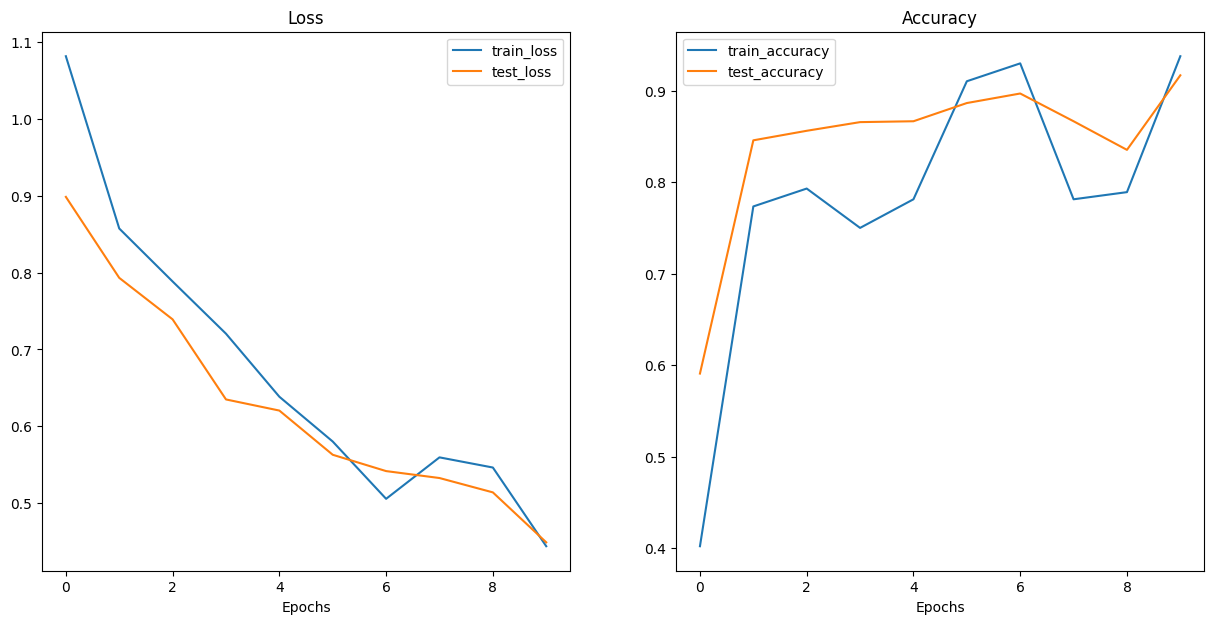

In [12]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

# 6. Make predictions on test images
We now want to see how our model works on individual cases and we'll plot a confusion matrix based on those results. 

In [14]:
from tqdm.auto import tqdm

y_preds = []
model.eval()
with torch.inference_mode():
    for x, y in tqdm(test_dataloader, desc="Making predictions"):
        x, y = x.to(device), y.to(device)

        y_logit = model(x)

        y_pred = torch.argmax(torch.softmax(y_logit, dim=1), dim=1)
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat([y for x, y in test_dataloader])

Making predictions: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


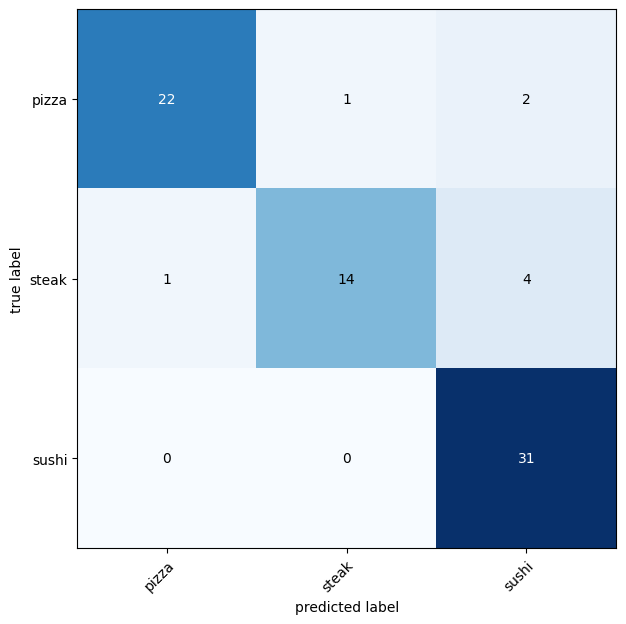

In [15]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=y_true_tensor)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
)

# 7. More analysis
In this section, we'll make predictions on all of the teste data to see which ones were the most wrong

In [53]:
from typing import List, Tuple
from PIL import Image

def pred_image(
        model: torch.nn.Module,
        image_paths_list: str,
        class_names: List[str],
        image_size: Tuple[int, int] = (224, 224),
        transform: torchvision.transforms = None,
        device: torch.device=device
):

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    res = []

    model.to(device)
    # Turn on evaluation and inference mode
    model.eval()
    with torch.inference_mode():
        for image_path in image_paths_list:
            actual_image = str(image_path).split("/")[3]

            # Open the image using PIL
            img = Image.open(image_path)

            # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
            transformed_image = image_transform(img).unsqueeze(dim=0)

            # Make a prediction on image with an extra dimension and send it to the target device
            target_image_pred = model(transformed_image.to(device))

            # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
            target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

            # Get the predicted label of the image
            image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

            # Get the confidence of the model for this classification
            # A larger difference means a less confident model
            difference = abs(1 - target_image_pred_probs.squeeze()[image_pred_label]).item()

            if class_names[image_pred_label] != actual_image:
                res.append((difference, image_path, class_names[image_pred_label], actual_image))
    
    return res

In [54]:
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))

res = pred_image(model=model,
                 image_paths_list=test_image_path_list,
                 class_names=class_names,
                 image_size=(224, 224),
                 transform=None,
                 device=device)


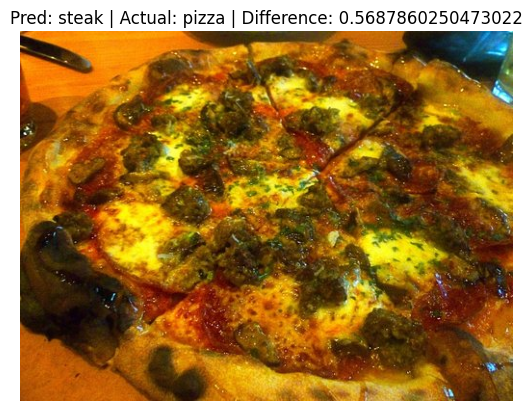

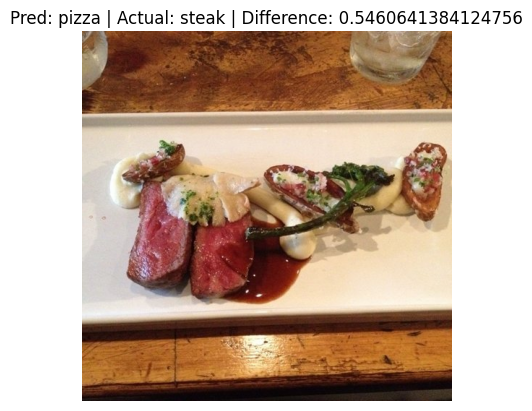

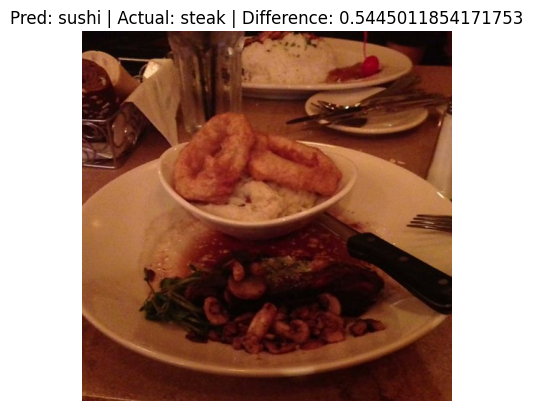

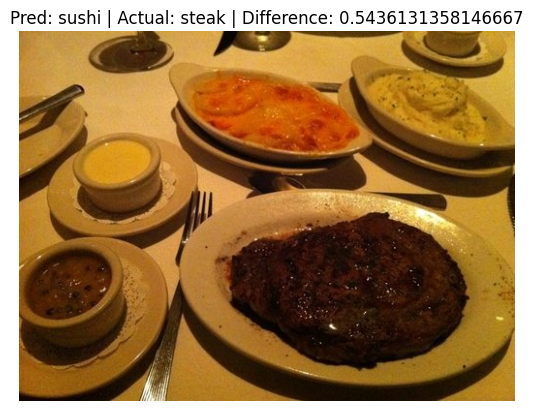

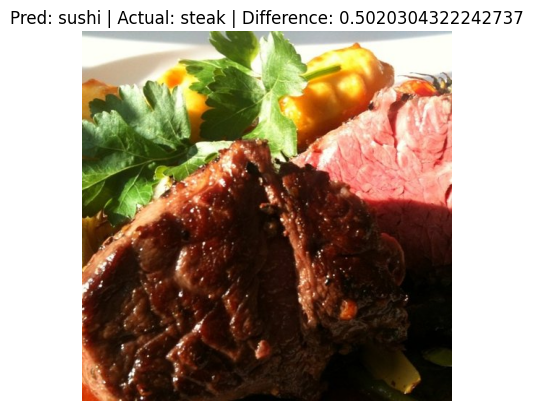

In [55]:
res = sorted(res, key=lambda x: x[0], reverse=True)

for i in range(5):
    difference = res[i][0]
    image_path = res[i][1]
    prediction = res[i][2]
    actual = res[i][3]

    img = Image.open(image_path)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {prediction} | Actual: {actual} | Difference: {difference}")
    plt.axis(False)